# Automatic Patent Classification

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use("classic")
sns.set()
from time import time

import os
import ipyparallel as ipp

rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()
pid_map

## Pre-processing...

### Importing data into pandas.DataFrame

In [2]:
### Importing data into pandas.DataFrame
# LOAD DATA DIRECTLY FROM .CSV INTO PYTHON_LIST()

t0 = time()
print('Importing data...')
try:
    dataset = open('dataset_ipc_first.csv', 'r', encoding='latin-1')
except:
    dataset = open('./output/dataset_ipc_first.csv', 'r', encoding='latin-1')
else:
    pass

if dataset:
    X_title, X_resume, y = [], [], []
    header = dataset.readline()
    if header[:-1] == 'title|resume|ipc':
        for line in dataset:
            line = line[:-1].split('|')
            if line[2][0:1] in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
                X_title.append(line[0])  # title
                X_resume.append(line[1]) # resume
                y.append(line[2][0:1])   # only first level IPC class (A..H)
    print('Number of occurences on X_title: ', len(X_title))
    print('Number of occurences on X_resume: ', len(X_resume))
    print('Number of occurences on y: ', len(y))

    categories = pd.DataFrame(y, columns = ['ipc_level1'])
print('done in %0.3fs.' % (time() - t0))

## LOAD DATA USING PANDAS
# corpora = pd.read_csv('dataset_ipc_first.csv', sep = '|', encoding = 'latin-1')
# create ipc_level1 column with IPC first level category
# categories = pd.DataFrame()
# categories['ipc_level1'] = corpora.apply(lambda row: row['ipc'][0:1], axis=1)


## REDUCE SAMPLE SIZE
# # reducing number of rows to 5000
# corpora = corpora[0:4999]
# categories = categories[0:4999]

Importing data...
Number of occurences on X:  347032
Number of occurences on X:  347032
Number of occurences on y:  347032
done in 3.383s.


### Analyzing data

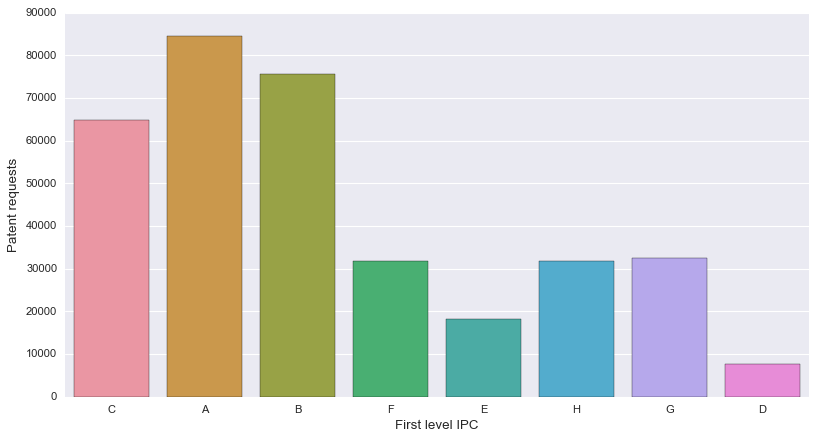

Total count of patent requests:  347032


In [3]:
### first look on data
plt.figure(figsize=(12,6))
ax = sns.countplot(x="ipc_level1", data=categories)
plt.ylabel('Patent requests', fontsize=12)
plt.xlabel('First level IPC', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()
print('Total count of patent requests: ', len(categories))

## Extracting features...

### Vectorization

In [4]:
### Vectorization
from time import time
from sklearn.feature_extraction.text import CountVectorizer

print('Extracting features...')
vec = CountVectorizer(ngram_range = (1, 1), max_df = .95, min_df = 1)
t0 = time()
X_title_features = vec.fit_transform(X_title)
print('Title vector matrix shape: ', X_title_features.shape)
X_resume_features = vec.fit_transform(X_resume)
print('Resume vector matrix shape: ', X_resume_features.shape)
print('done in %0.3fs.' % (time() - t0))

Extracting features...
Title vector matrix shape:  (347032, 64585)
Resume vector matrix shape:  (347032, 254990)
done in 104.038s.


### Reducing deminsionality

In [ ]:
### Reducing deminsionality with SVD
from sklearn.decomposition import TruncatedSVD

print('Selecting most relevant features...')
svd = TruncatedSVD(n_components = 500)
t0 = time()
X_title_svd = svd.fit_transform(X_title_features)
print('Title most relevant features matrix shape: ', X_title_svd.shape)
X_resume_svd = svd.fit_transform(X_resume_features)
print('Resume most relevant features matrix shape: ', X_resume_svd.shape)
print('done in %0.3fs.' % (time() - t0))

Selecting most relevant features...


### Categories binarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer
y_binarized = LabelBinarizer().fit_transform(y)
print(y_binarized)

## Sampling...

In [ ]:
from sklearn.model_selection import train_test_split

X_concatenated = np.concatenate((X_title_svd, X_resume_svd), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_concatenated, y_binarized, test_size=0.2, random_state=583)

## Training...

### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

### Measuring...

In [ ]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['A','B','C','D','E','F','G','H']
    
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,6))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
# plt.ylabel('Patent requests', fontsize=12)
# plt.xlabel('First level IPC', fontsize=12)
# plt.xticks(rotation='horizontal')
plt.show()